<a href="https://colab.research.google.com/github/gremlin97/EVA-8/blob/main/Assignment%202.5/EVA_2_5_KunalKasodekar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

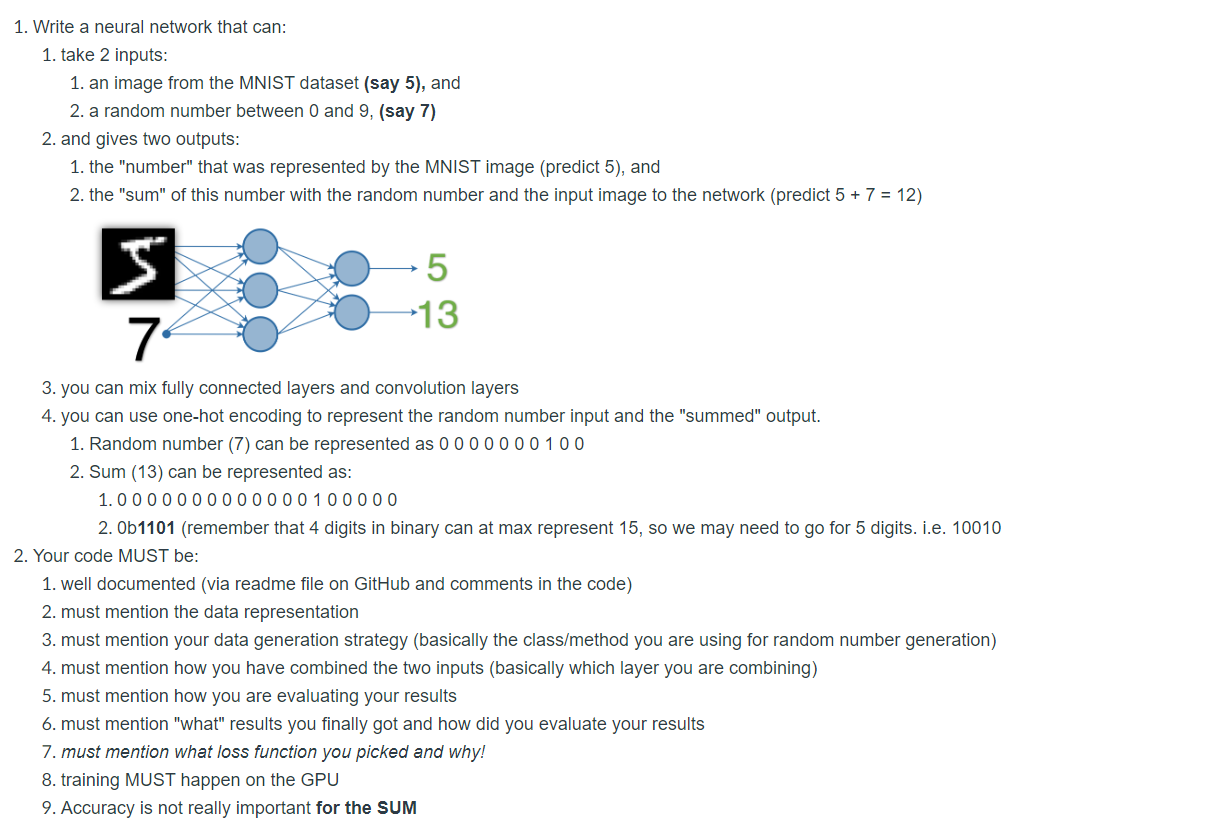

In [ ]:
!pip install idx2numpy
!pip install torchinfo
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7919 sha256=6ade896c43fa4ebd836dda949e8a7411c300e56bd881279eb3a67319bc166fe7
  Stored in directory: /root/.cache/pip/wheels/27/40/a8/6447ee4a00cb87e2084e1ef1df5c38433720cc1090be082842
Successfully built idx2numpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Required Libraries
import numpy as np
import idx2numpy
import os
import urllib.request as download
import torch
import torchvision
from torchsummary import summary
import gzip
import shutil
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as visiondataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Set Device
root = '/content/working' # Root Dir

if not os.path.exists(root): # Check if root dir exists else create root dir
  os.mkdir('/content/working')

In [ ]:
transform = transforms.Compose([
                           transforms.ToTensor(), # Convert to Tensor
                           transforms.Normalize((0.1307,), (0.3081,)) # Normalizing (Mean,Standard Deviation), (0,1)
                           ])

In [ ]:
resources = [
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
  ]

In [ ]:
# Downloading the MNIST Dataset (Train + Test) from the Original URL's (Yan Lee Cuns Website)
url_train = resources[0]
url_train_str = str(url_train)
download.urlretrieve(url_train_str,'/content/working/train.ubyte.gz')

url_test = resources[2]
url_test_str = str(url_test)
download.urlretrieve(url_test_str,'/content/working/test.ubyte.gz')

url_train_labels = resources[1]
url_train_labels_str = str(url_train_labels)
download.urlretrieve(url_train_labels_str,'/content/working/train_labels.ubyte.gz')

url_test_labels = resources[3]
url_test_labels_str = str(url_test_labels)
download.urlretrieve(url_test_labels_str,'/content/working/test_labels.ubyte.gz')

# Uncompressing the gz files
with gzip.open('/content/working/train.ubyte.gz', 'rb') as f_in, open('/content/working/train.ubyte','wb') as f_out:
  shutil.copyfileobj(f_in, f_out)

with gzip.open('/content/working/train_labels.ubyte.gz', 'rb') as f_in, open('/content/working/train_labels.ubyte','wb') as f_out:
  shutil.copyfileobj(f_in, f_out)

with gzip.open('/content/working/test.ubyte.gz', 'rb') as f_in, open('/content/working/test.ubyte','wb') as f_out:
  shutil.copyfileobj(f_in, f_out)

with gzip.open('/content/working/test_labels.ubyte.gz', 'rb') as f_in, open('/content/working/test_labels.ubyte','wb') as f_out:
  shutil.copyfileobj(f_in, f_out)

In [ ]:
dir = '/content/working' # Setting working dir

In [ ]:
'''
  Summary of RandomMNIST Custom Dataset: 

  Random MNIST creates an MNIST dataset which uses the original uncompressed MNIST Files, converts them to Train and Test Numpy arrays 
  respectively and converts them to appropriate tensors. It also randomly generates a random number as a class variable for each image.
  
  __getitem__: Returns the image, corresponding label, random number and sum between the random number and label (As Tensors)

  __item__: Returns the length of the dataset

  Attributes:

  arr: Numpy array of dataset (Train/Test)
  labels_arr: Corresponding Labels array of arr

  Arguments:

  dir: Working Directory
  train: (Bool) True to generate train, False to generate Test Dataset
  transform: Dataset Transform

'''
class RandomMNIST(Dataset):
  def __init__(self, dir, train, transform):
    if train == True:
      self.arr = idx2numpy.convert_from_file(dir + '/' + 'train.ubyte')
      self.labels_arr = idx2numpy.convert_from_file(dir + '/' + 'train_labels.ubyte')
    else:
      self.arr = idx2numpy.convert_from_file(dir + '/' + 'test.ubyte')
      self.labels_arr = idx2numpy.convert_from_file(dir + '/' + 'test_labels.ubyte')

    self.transform = transform
   
  def __getitem__(self, idx):
    image = self.arr[idx]
    label = self.labels_arr[idx]

    if self.transform:
      image = self.transform(image)

    rand = np.random.randint(9)
    sum = label + rand
    rand = torch.tensor(rand, dtype=torch.float32)
    rand = rand.unsqueeze(0)
    label = torch.tensor(label, dtype=torch.int64)
    sum = torch.tensor(sum, dtype=torch.int64)

    return image, rand, label, sum  

  def __len__(self):
    return self.arr.shape[0]

# Creating Train and Test Set
train = RandomMNIST(dir, True, transform)
test = RandomMNIST(dir, False, transform)

In [ ]:
# Checking out the dataset and dataloaders contents and attributes below:
image, random, label, sum = next(iter(train))
image.shape, random.shape, label, sum

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


(torch.Size([1, 28, 28]), torch.Size([1]), tensor(5), tensor(8))

In [ ]:
image, label, random, sum = next(iter(test))
image.shape, random, label, sum

(torch.Size([1, 28, 28]), tensor(7), tensor([7.]), tensor(14))

In [ ]:
# Created Trainloader with a Batch Size of 64 and Shuffle = True
train_loader = DataLoader(train,batch_size = 16, shuffle=True)
test_loader = DataLoader(test,batch_size = 16, shuffle=True)

In [ ]:
image, random, label, sum = next(iter(train_loader))

Labels tensor([[7, 3, 1, 3, 2, 8, 7, 0, 8, 2, 6, 4, 7, 1, 7, 8]])


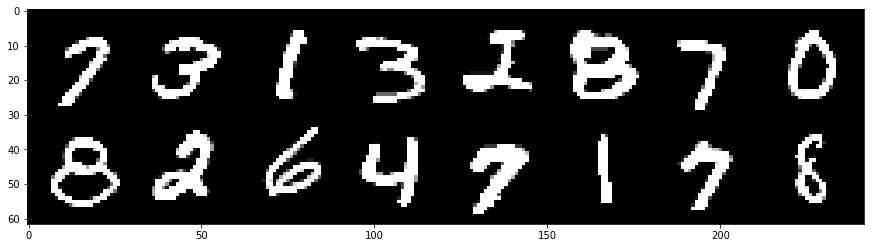

In [ ]:
# Plotting the train batch with its corresponding labels
import matplotlib.pyplot as plt
grid = torchvision.utils.make_grid(image,nrow=8)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print("Labels",label.reshape(1,-1))

In [ ]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, next(iter(train_loader))[2].shape, next(iter(train_loader))[3].shape

(torch.Size([16, 1, 28, 28]),
 torch.Size([16, 1]),
 torch.Size([16]),
 torch.Size([16]))

In [ ]:
next(iter(train_loader))[0].dtype, next(iter(train_loader))[1].dtype, next(iter(train_loader))[2].dtype, next(iter(train_loader))[3].dtype

(torch.float32, torch.float32, torch.int64, torch.int64)

In [ ]:
next(iter(train_loader))

[tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
       

## Model Architecture
Architecture of the Model to Predict MNIST Digit and the sum between a random number for each image and its digit.

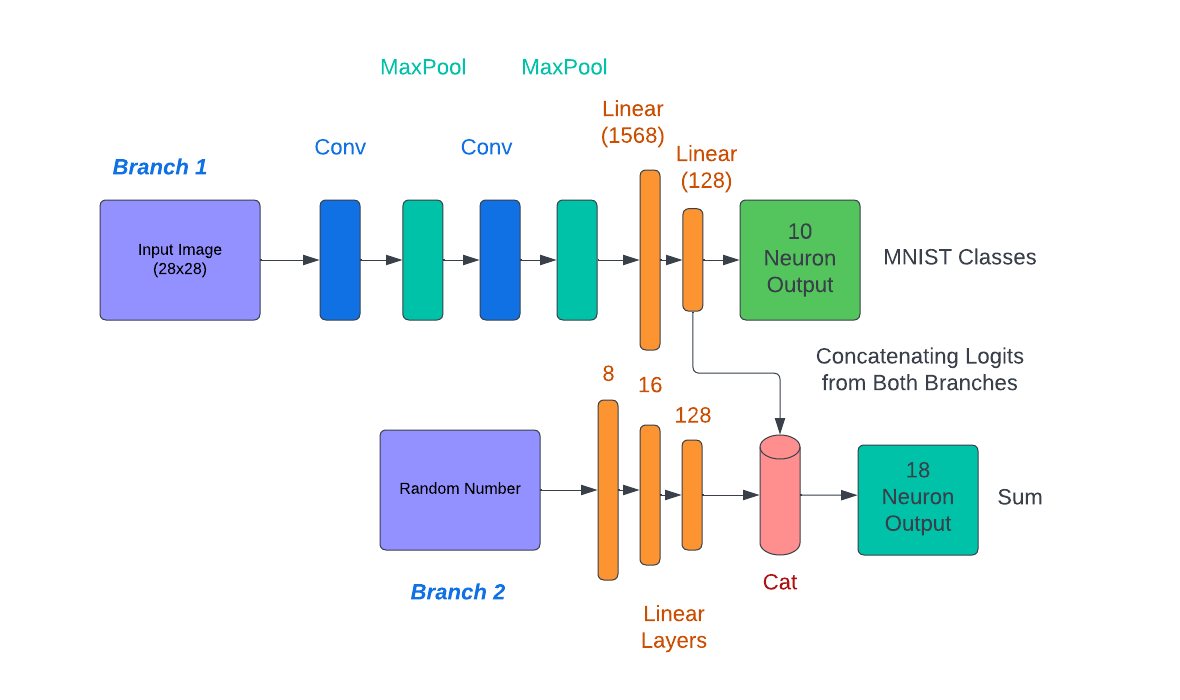

In [ ]:
'''
  Summary of RandomNet Neural Network:

  Two branches are created to predict both the MNIST Digit and the sum of the label and random number.The first branch applies a 
  convolutional  block till a receptive field of 14 is reached (>11), those features are flattened to a size of 128, and relevant features 
  are extracted from the images. The other branch accepts a random number from the batch in the forward function, is passed through a set of
  linear layers till we obtain logits in a flattened array of size 128. The first branch is continued through linear layers and an output of
  size 10 is obtained which corresponds to the output size. In the second branch the logits of size 128 are concatenated with the 128 
  logits/features and passed though another layer to obtain a class output of 18 neurons (max sum of the output of sum and label)
  
  Attributes:
    random: Random number for the image in the batch
    image: Image from the batch
    label: Digit prediction corresponding to the image
    sum: random + label
  
  Output and Output Shape:
    out: Predicted MNIST Digit, shape: [batch_size,10]
    rand: Predicted sum of the label and random number: [batch_size,18]

'''
class RandomNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, padding=1) #in: 28x28, out: 28x28, RF: 3
    self.pool1 = nn.MaxPool2d(2,2)  #in: 28x28, out: 14x14, RF: 6
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding=1) #in: 14x14, out: 14x14, RF: 8
    self.pool2 = nn.MaxPool2d(2,2)  #in: 14x14, out: 7x7, RF: 12
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding=1) #in: 14x14, out: 7x7, RF: 14
    # self.pool3 = nn.MaxPool2d(2,2)  #in: 7x7, out: 3x3, RF: 28

    self.fc1 = nn.Linear(7*7*32, 128)
    self.fc2 = nn.Linear(128,10)

    self.fcr1 = nn.Linear(1,8)
    self.fcr2 = nn.Linear(8,16)
    self.fcr3 = nn.Linear(16,128)

    self.combinedfc = nn.Linear(256,18)
  
  def forward(self, image, random):
    x = self.conv1(image)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = x.reshape(-1,7*7*32) # Reshape to 1D (1 R, N Col)
    logits = self.fc1(x) # Use print(logits.size()) to print ouput shape
    
    r = self.fcr1(random)
    r = F.relu(r)
    r = self.fcr2(r)
    r = F.relu(r)
    r = self.fcr3(r)

    concat_logits = torch.concatenate([r,logits],dim=1)
    rand = self.combinedfc(concat_logits)
    x = F.relu(logits)

    out = self.fc2(x)

    return out, rand

rand = RandomNet() # Instantiating the Net

for name, param in rand.named_parameters(): # Printing param shapes
  print(name,'\t\t',param.shape)

conv1.weight 		 torch.Size([8, 1, 3, 3])
conv1.bias 		 torch.Size([8])
conv2.weight 		 torch.Size([16, 8, 3, 3])
conv2.bias 		 torch.Size([16])
conv3.weight 		 torch.Size([32, 16, 3, 3])
conv3.bias 		 torch.Size([32])
fc1.weight 		 torch.Size([128, 1568])
fc1.bias 		 torch.Size([128])
fc2.weight 		 torch.Size([10, 128])
fc2.bias 		 torch.Size([10])
fcr1.weight 		 torch.Size([8, 1])
fcr1.bias 		 torch.Size([8])
fcr2.weight 		 torch.Size([16, 8])
fcr2.bias 		 torch.Size([16])
fcr3.weight 		 torch.Size([128, 16])
fcr3.bias 		 torch.Size([128])
combinedfc.weight 		 torch.Size([18, 256])
combinedfc.bias 		 torch.Size([18])


## Model Architecture for MNIST CNN Predictor
Architecture of the Model to Predict MNIST Digit as a ***Sanity Check***

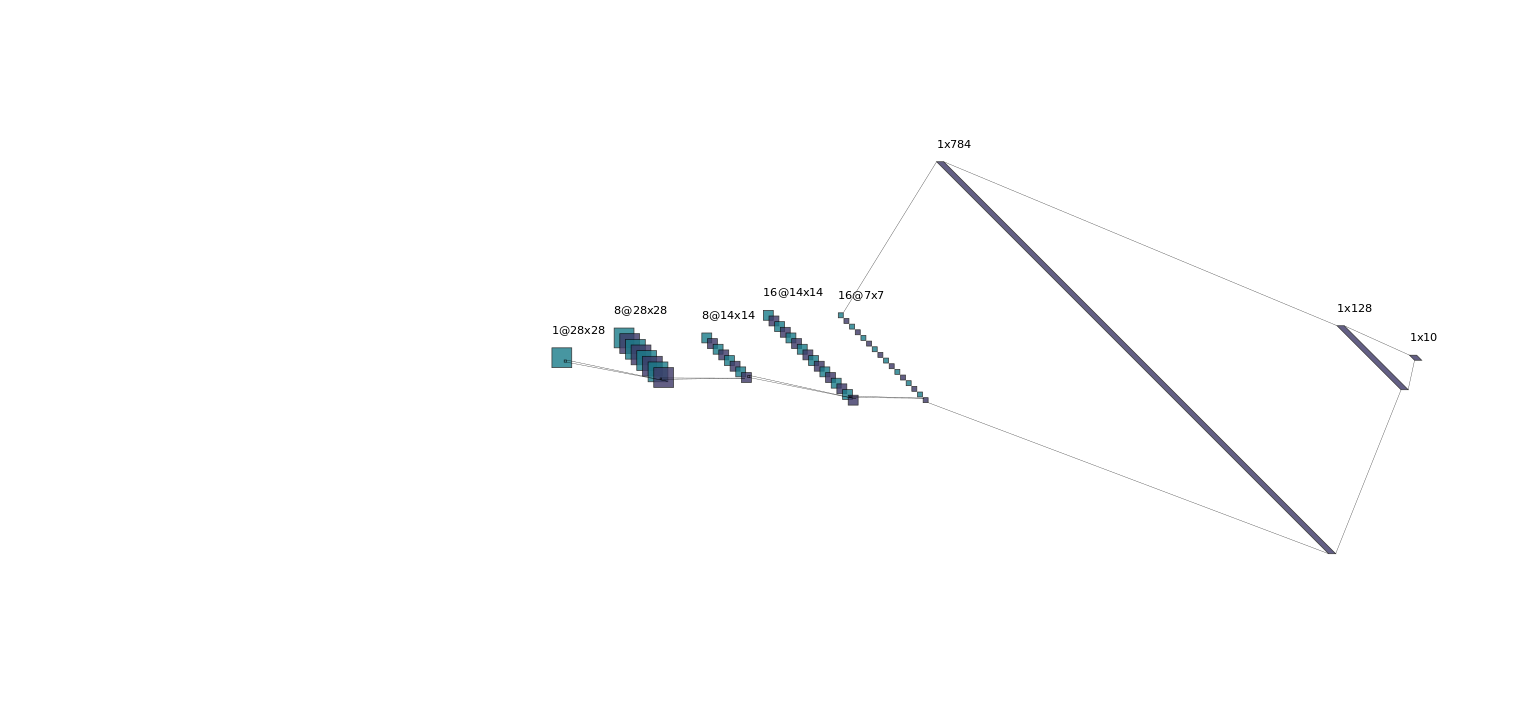

In [ ]:
class NormalNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, padding=1) #in: 28x28, out: 28x28, RF: 3
    self.pool1 = nn.MaxPool2d(2,2)  #in: 28x28, out: 14x14, RF: 6
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding=1) #in: 14x14, out: 14x14, RF: 8
    self.pool2 = nn.MaxPool2d(2,2)  #in: 14x14, out: 7x7, RF: 12
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding=1) #in: 14x14, out: 7x7, RF: 14

    self.fc1 = nn.Linear(7*7*32, 128)
    self.fc2 = nn.Linear(128,10)
  
  def forward(self, image):
    x = self.conv1(image)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = x.reshape(-1,7*7*32) # Reshape to 1D (1 R, N Col)
    x = self.fc1(x)
    
    x = F.relu(x)

    out = self.fc2(x)

    return out

norm = NormalNet()

for name, param in norm.named_parameters():
  print(name,'\t\t',param.shape)

conv1.weight 		 torch.Size([8, 1, 3, 3])
conv1.bias 		 torch.Size([8])
conv2.weight 		 torch.Size([16, 8, 3, 3])
conv2.bias 		 torch.Size([16])
conv3.weight 		 torch.Size([32, 16, 3, 3])
conv3.bias 		 torch.Size([32])
fc1.weight 		 torch.Size([128, 1568])
fc1.bias 		 torch.Size([128])
fc2.weight 		 torch.Size([10, 128])
fc2.bias 		 torch.Size([10])


In [ ]:
# Checking out the model params, outputs and output shapes
out1, out2 = rand(torch.randn(64,1,28,28),torch.randn(64,1))
out1.shape, out2.shape

(torch.Size([64, 10]), torch.Size([64, 18]))

In [ ]:
torch.randn(1,1).shape

torch.Size([1, 1])

In [ ]:
from torchinfo import summary
summary(rand)

Layer (type:depth-idx)                   Param #
RandomNet                                --
├─Conv2d: 1-1                            80
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            1,168
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            4,640
├─Linear: 1-6                            200,832
├─Linear: 1-7                            1,290
├─Linear: 1-8                            16
├─Linear: 1-9                            144
├─Linear: 1-10                           2,176
├─Linear: 1-11                           4,626
Total params: 214,972
Trainable params: 214,972
Non-trainable params: 0

In [ ]:
rand.to(device) # Sending the model to GPU (cuda:0)

RandomNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (fcr1): Linear(in_features=1, out_features=8, bias=True)
  (fcr2): Linear(in_features=8, out_features=16, bias=True)
  (fcr3): Linear(in_features=16, out_features=128, bias=True)
  (combinedfc): Linear(in_features=256, out_features=18, bias=True)
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=3ada8160728438eda8a5e8c6da260a25db4893a2c3d5f1a854ae71c0e972089d
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


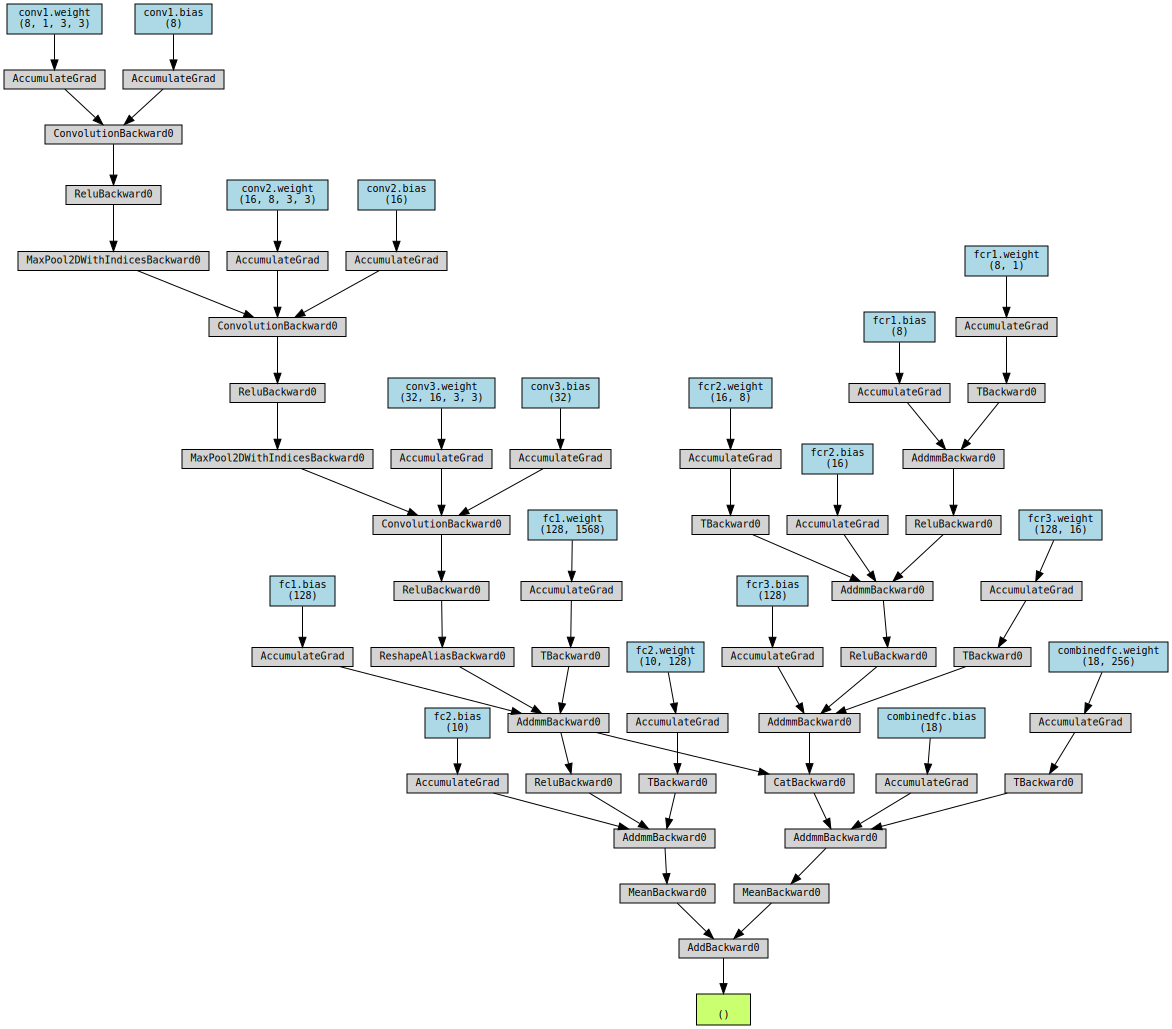

In [ ]:
# Installing libraries to display model architecture using torchviz
!pip install torchviz
from graphviz import Digraph
from torchviz import make_dot

y = rand(torch.randn(1,1,28,28).to(device),torch.randn(1,1).to(device))
make_dot(y[0].mean()+y[1].mean(), params=dict(rand.named_parameters())) # Passing the mean of both outputs

In [ ]:
torch.manual_seed(0) # Setting seed for the experiments

In [ ]:
optimizer = torch.optim.Adam(rand.parameters(),lr=1e-3) # Using Adam optimizer with learning rate of 0.001
scheduler =  StepLR(optimizer, step_size=5, gamma=0.1) # Using an LR Scheduler (Step) that decreases the LR by 0.1 every 5 epochs 
epochs = 20 # Training for 20 Epochs

In [ ]:
# Training Loop
for epoch in range(epochs):
  total_loss = 0
  total_correct_img = 0
  total_correct = 0
  for batch in train_loader: # Looping over the batches
    images, random, label, sum = batch
    # Putting tensors on the GPU
    images = images.to(device)
    random = random.to(device)
    label = label.to(device)
    sum = sum.to(device)
    pred_img, pred_sum = rand(images,random) #Predicting both the image and sum

    loss_img = F.cross_entropy(pred_img, label) # Calculating loss individually w.r.t targets for both the image and label
    loss_rand = F.cross_entropy(pred_sum, sum)

    '''
     Experimented with various pardigmns for optimization and backprop. This works well wherein we do torch.autograd.backward to 
     update leaf nodes/variables grad attributes with the sum of the grads calculated for the respective losses.
    '''

    #loss_total = loss_img + loss_rand  # Calculating total loss
    optimizer.zero_grad() # Clearing accumulated gradients
    #loss_total.backward() 

    # loss_img.backward(retain_graph=True)
    # loss_rand.backward()
    torch.autograd.backward([loss_img,loss_rand]) # Calculate gradients via backpropogation

    optimizer.step() # Optimization Step to Update Weights
    #total_loss += loss_total.item()
    total_loss += loss_img.item() + loss_rand.item()  # Calculating total loss
    correct = pred_sum.argmax(dim=1).eq(sum).sum().item() # Finding total correct predictions for random numbers
    total_correct += correct 
    total_correct_img += pred_img.argmax(dim=1).eq(label).sum().item() # Finding total correctly predicted images

  scheduler.step() # Scheduler step (After optimization)

  print(
      "Epoch:",epoch,
      "Total Correct Sum:",total_correct,
      "Total Correct Images:",total_correct_img,
      "Total Loss:",total_loss,
      "Sum Accuracy:",total_correct/train.__len__(),
      "Image Accuracy:",total_correct_img/train.__len__()
  )

Epoch: 0 Total Correct Sum: 28159 Total Correct Images: 58809 Total Loss: 5112.470850021491 Sum Accuracy: 0.46931666666666666 Image Accuracy: 0.98015
Epoch: 1 Total Correct Sum: 34702 Total Correct Images: 59263 Total Loss: 4144.22789285105 Sum Accuracy: 0.5783666666666667 Image Accuracy: 0.9877166666666667
Epoch: 2 Total Correct Sum: 37783 Total Correct Images: 59439 Total Loss: 3736.5178454122397 Sum Accuracy: 0.6297166666666667 Image Accuracy: 0.99065
Epoch: 3 Total Correct Sum: 39549 Total Correct Images: 59557 Total Loss: 3489.5640436831745 Sum Accuracy: 0.65915 Image Accuracy: 0.9926166666666667
Epoch: 4 Total Correct Sum: 41157 Total Correct Images: 59649 Total Loss: 3297.333297299596 Sum Accuracy: 0.68595 Image Accuracy: 0.99415
Epoch: 5 Total Correct Sum: 47877 Total Correct Images: 59868 Total Loss: 2658.822757170232 Sum Accuracy: 0.79795 Image Accuracy: 0.9978
Epoch: 6 Total Correct Sum: 48851 Total Correct Images: 59915 Total Loss: 2519.897991235536 Sum Accuracy: 0.81418333

In [ ]:
# Here we do a Sanity Check to initially to verify that our NormalNet, the MNIST Digit prediction branch of our Random Net
# Works properly. The loop is self explanatory after reviewing the above code comments.

norm.to(device)

optimizer_n = torch.optim.Adam(norm.parameters(),lr=1e-3)
scheduler_n =  StepLR(optimizer_n, step_size=5, gamma=0.1)
epochs = 20

for epoch in range(epochs):
  total_loss = 0
  total_correct_img = 0
  total_correct = 0
  for batch in train_loader:
    images, random, label, sum = batch
    images = images.to(device)
    random = random.to(device)
    label = label.to(device)
    sum = sum.to(device)
    pred_img = norm(images)

    loss_img = F.cross_entropy(pred_img, label)

    optimizer_n.zero_grad() # Clearing accumulated gradients

    loss_img.backward()

    optimizer_n.step() # Optimization Step to Update Weights
    total_loss += loss_img.item() 
    total_correct_img += pred_img.argmax(dim=1).eq(label).sum().item()
  
  scheduler_n.step()

  print(
      "Epoch:",epoch,
      "Total Correct Images:",total_correct_img,
      "Loss:",total_loss,
      "Image Accuracy:",(total_correct_img/train.__len__())
  )

Epoch: 0 Total Correct Images: 57413 Loss: 517.3783437413658 Image Accuracy: 0.9568833333333333
Epoch: 1 Total Correct Images: 59071 Loss: 194.3510439219108 Image Accuracy: 0.9845166666666667
Epoch: 2 Total Correct Images: 59335 Loss: 133.70821910067207 Image Accuracy: 0.9889166666666667
Epoch: 3 Total Correct Images: 59441 Loss: 106.52472695739988 Image Accuracy: 0.9906833333333334
Epoch: 4 Total Correct Images: 59566 Loss: 84.76129208022263 Image Accuracy: 0.9927666666666667
Epoch: 5 Total Correct Images: 59871 Loss: 27.002885607689137 Image Accuracy: 0.99785
Epoch: 6 Total Correct Images: 59940 Loss: 13.6316475954112 Image Accuracy: 0.999
Epoch: 7 Total Correct Images: 59969 Loss: 8.261699501101585 Image Accuracy: 0.9994833333333333
Epoch: 8 Total Correct Images: 59978 Loss: 5.499090480986629 Image Accuracy: 0.9996333333333334
Epoch: 9 Total Correct Images: 59983 Loss: 3.6671477556482195 Image Accuracy: 0.9997166666666667
Epoch: 10 Total Correct Images: 59992 Loss: 1.524664549929466

In [1]:
# Saved training logs of Random Net

Loss_logs = [(
    '''
      Epoch: 0 Total Correct Sum: 28159 Total Correct Images: 58809 Total Loss: 5112.470850021491 Sum Accuracy: 0.46931666666666666 Image Accuracy: 0.98015
      Epoch: 1 Total Correct Sum: 34702 Total Correct Images: 59263 Total Loss: 4144.22789285105 Sum Accuracy: 0.5783666666666667 Image Accuracy: 0.9877166666666667
      Epoch: 2 Total Correct Sum: 37783 Total Correct Images: 59439 Total Loss: 3736.5178454122397 Sum Accuracy: 0.6297166666666667 Image Accuracy: 0.99065
      Epoch: 3 Total Correct Sum: 39549 Total Correct Images: 59557 Total Loss: 3489.5640436831745 Sum Accuracy: 0.65915 Image Accuracy: 0.9926166666666667
      Epoch: 4 Total Correct Sum: 41157 Total Correct Images: 59649 Total Loss: 3297.333297299596 Sum Accuracy: 0.68595 Image Accuracy: 0.99415
      Epoch: 5 Total Correct Sum: 47877 Total Correct Images: 59868 Total Loss: 2658.822757170232 Sum Accuracy: 0.79795 Image Accuracy: 0.9978
      Epoch: 6 Total Correct Sum: 48851 Total Correct Images: 59915 Total Loss: 2519.897991235536 Sum Accuracy: 0.8141833333333334 Image Accuracy: 0.9985833333333334
      Epoch: 7 Total Correct Sum: 49071 Total Correct Images: 59946 Total Loss: 2454.4323104869627 Sum Accuracy: 0.81785 Image Accuracy: 0.9991
      Epoch: 8 Total Correct Sum: 49490 Total Correct Images: 59954 Total Loss: 2402.9007057838 Sum Accuracy: 0.8248333333333333 Image Accuracy: 0.9992333333333333
      Epoch: 9 Total Correct Sum: 49688 Total Correct Images: 59966 Total Loss: 2379.673212336805 Sum Accuracy: 0.8281333333333334 Image Accuracy: 0.9994333333333333
      Epoch: 10 Total Correct Sum: 50180 Total Correct Images: 59978 Total Loss: 2313.3469033602573 Sum Accuracy: 0.8363333333333334 Image Accuracy: 0.9996333333333334
      Epoch: 11 Total Correct Sum: 50451 Total Correct Images: 59977 Total Loss: 2283.1148818198567 Sum Accuracy: 0.84085 Image Accuracy: 0.9996166666666667
      Epoch: 12 Total Correct Sum: 50449 Total Correct Images: 59977 Total Loss: 2282.096609179364 Sum Accuracy: 0.8408166666666667 Image Accuracy: 0.9996166666666667
      Epoch: 13 Total Correct Sum: 50437 Total Correct Images: 59977 Total Loss: 2281.1828584418395 Sum Accuracy: 0.8406166666666667 Image Accuracy: 0.9996166666666667
      Epoch: 14 Total Correct Sum: 50468 Total Correct Images: 59978 Total Loss: 2252.2314270460797 Sum Accuracy: 0.8411333333333333 Image Accuracy: 0.9996333333333334
      Epoch: 15 Total Correct Sum: 50555 Total Correct Images: 59979 Total Loss: 2290.658310729588 Sum Accuracy: 0.8425833333333334 Image Accuracy: 0.99965
      Epoch: 16 Total Correct Sum: 50519 Total Correct Images: 59979 Total Loss: 2260.247196971777 Sum Accuracy: 0.8419833333333333 Image Accuracy: 0.99965
      Epoch: 17 Total Correct Sum: 50514 Total Correct Images: 59979 Total Loss: 2277.3647829075217 Sum Accuracy: 0.8419 Image Accuracy: 0.99965
      Epoch: 18 Total Correct Sum: 50654 Total Correct Images: 59979 Total Loss: 2248.957679862456 Sum Accuracy: 0.8442333333333333 Image Accuracy: 0.99965
      Epoch: 19 Total Correct Sum: 50572 Total Correct Images: 59979 Total Loss: 2250.7952094561547 Sum Accuracy: 0.8428666666666667 Image Accuracy: 0.99965
    '''
    ,
    '''
     Epoch: 0 Total Correct: 25197 Total Correct Images: 58230 Loss: 1.0580025911331177 Sum Accuracy: 0.41995 Image Accuracy: 0.9705
    Epoch: 1 Total Correct: 34460 Total Correct Images: 59254 Loss: 1.1102770864963531 Sum Accuracy: 0.5743333333333334 Image Accuracy: 0.9875666666666667
    Epoch: 2 Total Correct: 37668 Total Correct Images: 59439 Loss: 0.9038642928935587 Sum Accuracy: 0.6278 Image Accuracy: 0.99065
    Epoch: 3 Total Correct: 39881 Total Correct Images: 59549 Loss: 1.588500349316746 Sum Accuracy: 0.6646833333333333 Image Accuracy: 0.9924833333333334
    Epoch: 4 Total Correct: 41397 Total Correct Images: 59593 Loss: 0.8106887647882104 Sum Accuracy: 0.68995 Image Accuracy: 0.9932166666666666
    Epoch: 5 Total Correct: 48281 Total Correct Images: 59860 Loss: 0.38063156968564726 Sum Accuracy: 0.8046833333333333 Image Accuracy: 0.9976666666666667
    Epoch: 6 Total Correct: 49149 Total Correct Images: 59905 Loss: 0.3384809614290134 Sum Accuracy: 0.81915 Image Accuracy: 0.9984166666666666
    Epoch: 7 Total Correct: 49466 Total Correct Images: 59929 Loss: 0.6633256559725851 Sum Accuracy: 0.8244333333333334 Image Accuracy: 0.9988166666666667
    Epoch: 8 Total Correct: 49553 Total Correct Images: 59937 Loss: 0.5482223332801368 Sum Accuracy: 0.8258833333333333 Image Accuracy: 0.99895
    Epoch: 9 Total Correct: 49630 Total Correct Images: 59950 Loss: 0.6610703746628133 Sum Accuracy: 0.8271666666666667 Image Accuracy: 0.9991666666666666
    Epoch: 10 Total Correct: 50468 Total Correct Images: 59972 Loss: 0.8481923531508073 Sum Accuracy: 0.8411333333333333 Image Accuracy: 0.9995333333333334
    Epoch: 11 Total Correct: 50407 Total Correct Images: 59973 Loss: 0.5151217428501695 Sum Accuracy: 0.8401166666666666 Image Accuracy: 0.99955
    Epoch: 12 Total Correct: 50378 Total Correct Images: 59974 Loss: 0.4910212531685829 Sum Accuracy: 0.8396333333333333 Image Accuracy: 0.9995666666666667
    Epoch: 13 Total Correct: 50407 Total Correct Images: 59974 Loss: 0.47970792889100267 Sum Accuracy: 0.8401166666666666 Image Accuracy: 0.9995666666666667
    Epoch: 14 Total Correct: 50537 Total Correct Images: 59975 Loss: 1.2680460136143665 Sum Accuracy: 0.8422833333333334 Image Accuracy: 0.9995833333333334
    Epoch: 15 Total Correct: 50494 Total Correct Images: 59979 Loss: 0.3732307219179347 Sum Accuracy: 0.8415666666666667 Image Accuracy: 0.99965
    Epoch: 16 Total Correct: 50661 Total Correct Images: 59979 Loss: 0.4400448156229686 Sum Accuracy: 0.84435 Image Accuracy: 0.99965
    Epoch: 17 Total Correct: 50614 Total Correct Images: 59979 Loss: 0.7322045542550768 Sum Accuracy: 0.8435666666666667 Image Accuracy: 0.99965
    Epoch: 18 Total Correct: 50629 Total Correct Images: 59979 Loss: 1.1139443628489971 Sum Accuracy: 0.8438166666666667 Image Accuracy: 0.99965
    Epoch: 19 Total Correct: 50519 Total Correct Images: 59979 Loss: 1.1734270639717579 Sum Accuracy: 0.8419833333333333 Image Accuracy: 0.99965
    ''',
    '''
    Epoch: 0 Total Correct: 24994 Total Correct Images: 58009 Loss: 1.6786536276340485 Sum Accuracy: 0.41656666666666664 Image Accuracy: 0.9668166666666667
    Epoch: 1 Total Correct: 33653 Total Correct Images: 59227 Loss: 0.7367602166486904 Sum Accuracy: 0.5608833333333333 Image Accuracy: 0.9871166666666666
    Epoch: 2 Total Correct: 36920 Total Correct Images: 59441 Loss: 2.4037311747670174 Sum Accuracy: 0.6153333333333333 Image Accuracy: 0.9906833333333334
    Epoch: 3 Total Correct: 38875 Total Correct Images: 59542 Loss: 0.8679653368890285 Sum Accuracy: 0.6479166666666667 Image Accuracy: 0.9923666666666666
    Epoch: 4 Total Correct: 40520 Total Correct Images: 59613 Loss: 0.6755946689772827 Sum Accuracy: 0.6753333333333333 Image Accuracy: 0.99355
    Epoch: 5 Total Correct: 47574 Total Correct Images: 59878 Loss: 0.7885043825954199 Sum Accuracy: 0.7929 Image Accuracy: 0.9979666666666667
    Epoch: 6 Total Correct: 48626 Total Correct Images: 59929 Loss: 0.67600476564985 Sum Accuracy: 0.8104333333333333 Image Accuracy: 0.9988166666666667
    Epoch: 7 Total Correct: 48838 Total Correct Images: 59943 Loss: 0.7899998782668263 Sum Accuracy: 0.8139666666666666 Image Accuracy: 0.99905
    Epoch: 8 Total Correct: 49084 Total Correct Images: 59958 Loss: 0.6330844123876886 Sum Accuracy: 0.8180666666666667 Image Accuracy: 0.9993
    Epoch: 9 Total Correct: 49330 Total Correct Images: 59968 Loss: 0.39457018786561093 Sum Accuracy: 0.8221666666666667 Image Accuracy: 0.9994666666666666
    Epoch: 10 Total Correct: 50073 Total Correct Images: 59983 Loss: 0.9593964765081182 Sum Accuracy: 0.83455 Image Accuracy: 0.9997166666666667
    Epoch: 11 Total Correct: 50152 Total Correct Images: 59983 Loss: 0.3564134389453102 Sum Accuracy: 0.8358666666666666 Image Accuracy: 0.9997166666666667
    Epoch: 12 Total Correct: 50175 Total Correct Images: 59982 Loss: 0.2667074873538695 Sum Accuracy: 0.83625 Image Accuracy: 0.9997
    Epoch: 13 Total Correct: 50236 Total Correct Images: 59981 Loss: 0.4812454587809043 Sum Accuracy: 0.8372666666666667 Image Accuracy: 0.9996833333333334
    Epoch: 14 Total Correct: 50319 Total Correct Images: 59983 Loss: 0.27486886792576115 Sum Accuracy: 0.83865 Image Accuracy: 0.9997166666666667
    Epoch: 15 Total Correct: 50390 Total Correct Images: 59984 Loss: 0.3603895604597369 Sum Accuracy: 0.8398333333333333 Image Accuracy: 0.9997333333333334
    Epoch: 16 Total Correct: 50242 Total Correct Images: 59984 Loss: 0.4148408840137563 Sum Accuracy: 0.8373666666666667 Image Accuracy: 0.9997333333333334
    Epoch: 17 Total Correct: 50283 Total Correct Images: 59984 Loss: 0.5959093793844659 Sum Accuracy: 0.83805 Image Accuracy: 0.9997333333333334
    Epoch: 18 Total Correct: 50349 Total Correct Images: 59984 Loss: 0.3229017183139149 Sum Accuracy: 0.83915 Image Accuracy: 0.9997333333333334
    Epoch: 19 Total Correct: 50334 Total Correct Images: 59984 Loss: 0.32100466638780745 Sum Accuracy: 0.8389 Image Accuracy: 0.9997333333333334

    '''
)]